In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io as sio
import cv2
from keras.utils import np_utils

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Conv3D, MaxPool3D, Conv2D, Conv1D, MaxPooling2D, Flatten, Dense, Reshape, Dropout, Average
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import layers
from keras import Model, Input

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from config.utils import *
from config.models import *

import spectral
from operator import truediv

In [2]:
print(tf.__version__)

<IPython.core.display.Javascript object>

2.3.1


In [3]:
######### GLOBAL PARAMETERS #########
dataset = 'PU'
testSize = 0.25
windowSize = 25

K = 30 if dataset == 'IP' else 15
#K = 15

PATH1 = 'saved_models/' + dataset + '/' + 'first' + dataset + '.hdf5'
PATH2 = 'saved_models/' + dataset + '/' + 'second' + dataset + '.hdf5'
######### GLOBAL PARAMETERS #########

In [4]:
input_shape = (25,25,K,1)
model_input = Input(shape=input_shape)

In [5]:
def ensemble(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y = keras.layers.Average()(outputs)
    model = Model(model_input, y)
    return model

In [6]:
def ensemble_try(models, X_Test):
    
    Y_Pred = [model.predict(X_Test) for model in models]
    Y_Pred = np.array(Y_Pred)
    #print('Before Summed Shape - ', Y_Pred.shape)
    summed = np.sum(Y_Pred, axis = 0)
    #print('After Summed Shape - ', Y_Pred.shape)
    result = np.argmax(summed, axis=1)
    
    return result

In [7]:
X, Y = loadData(dataset)
units, target_names = targets(dataset)

X,pca = applyPCA(X,N=K)
ev=pca.explained_variance_ratio_
print('X.shape',X.shape)
print('y.shape',Y.shape)

X , Y = createImageCubes(X,Y,windowSize=windowSize)

X_Train , X_Test , Y_Train, Y_Test = train_test_split(X,Y,test_size=testSize,random_state=345)

Y_Train = np_utils.to_categorical(Y_Train)
Y_Test = np_utils.to_categorical(Y_Test)

X_Train = X_Train.reshape(-1, windowSize, windowSize, K, 1)
X_Test = X_Test.reshape(-1, windowSize, windowSize,K, 1)

X.shape (610, 340, 15)
y.shape (610, 340)


In [8]:
Hybrid1 = make_3d_1(9, dataset)
Hybrid2 = make_3d_2(9, dataset)

for layers in Hybrid1.layers:
    layers.trainable = True

for layers in Hybrid2.layers:
    layers.trainable = True
    
adam = Adam(lr=0.001, decay=1e-06)
Hybrid1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
Hybrid2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Hybrid1.load_weights(PATH1)
Hybrid2.load_weights(PATH2)

models = [Hybrid1, Hybrid2]

In [9]:
loss_val, acc_val = Hybrid1.evaluate(X_Test, Y_Test, verbose=1)

335/335 [==============================] - 10s 29ms/step - loss: 0.4494 - accuracy: 0.9270


In [10]:
loss_val, acc_val = Hybrid2.evaluate(X_Test, Y_Test, verbose=1)

335/335 [==============================] - 8s 24ms/step - loss: 0.3154 - accuracy: 0.9151


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

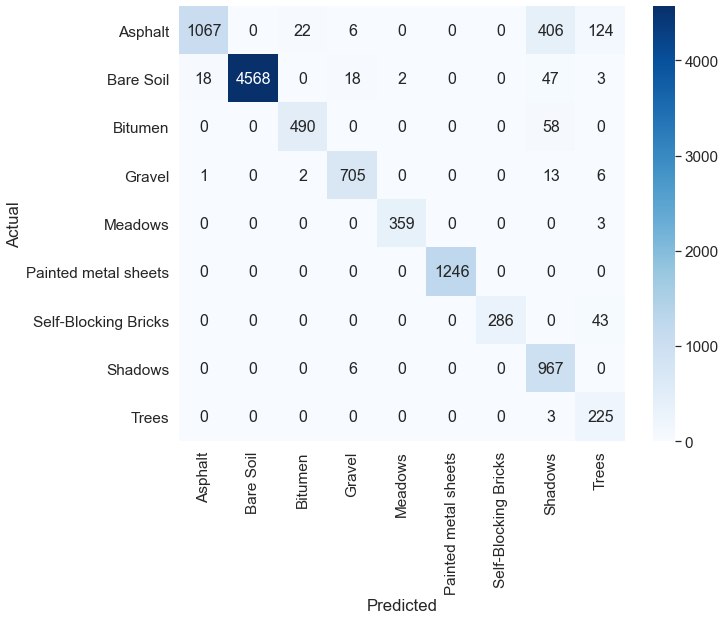

In [12]:
Y_Pred = Hybrid1.predict(X_Test)
Y_Pred = np.argmax(Y_Pred, axis=1)

Matrix = (confusion_matrix(np.argmax(Y_Test, axis=1), Y_Pred))

df_cm = pd.DataFrame(Matrix, columns=np.unique(target_names), index = np.unique(target_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')
#plt.savefig('cmap_IP_first_model.png', dpi=300)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

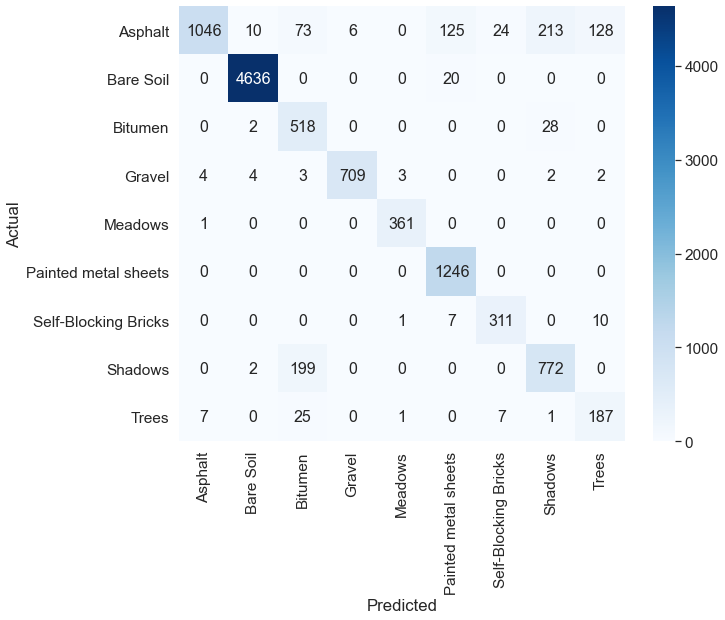

In [13]:
Y_Pred = Hybrid2.predict(X_Test)
Y_Pred = np.argmax(Y_Pred, axis=1)

Matrix = (confusion_matrix(np.argmax(Y_Test, axis=1), Y_Pred))

df_cm = pd.DataFrame(Matrix, columns=np.unique(target_names), index = np.unique(target_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')
#plt.savefig('cmap_IP_first_model.png', dpi=300)

In [14]:
Hybrid1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 23, 23, 11, 8)     368       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 9, 16)     3472      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 10, 4, 16)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 4, 16)     64        
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [15]:
Hybrid2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 23, 23, 9, 8)      512       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 21, 21, 5, 16)     5776      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 19, 19, 3, 16)     6928      
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 17, 17, 1, 16)     6928      
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 17, 1, 16)     64        
_________________________________________________________________
reshape_1 (Reshape)          (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)       

In [16]:
Y_Pred = ensemble_try(models, X_Test)
Y_Pred.shape

(10694,)

In [17]:
Report = (classification_report(np.argmax(Y_Test, axis=1), Y_Pred, target_names=target_names))

In [18]:
print(Report)

                      precision    recall  f1-score   support

             Asphalt       1.00      0.73      0.84      1625
             Meadows       1.00      1.00      1.00      4656
              Gravel       0.95      0.94      0.94       548
               Trees       0.99      0.98      0.99       727
Painted metal sheets       1.00      0.99      1.00       362
           Bare Soil       0.93      1.00      0.97      1246
             Bitumen       1.00      0.92      0.96       329
Self-Blocking Bricks       0.74      0.98      0.84       973
             Shadows       0.72      0.98      0.83       228

            accuracy                           0.95     10694
           macro avg       0.93      0.95      0.93     10694
        weighted avg       0.96      0.95      0.95     10694



In [18]:
Matrix = (confusion_matrix(np.argmax(Y_Test, axis=1), Y_Pred))
#print(Matrix)

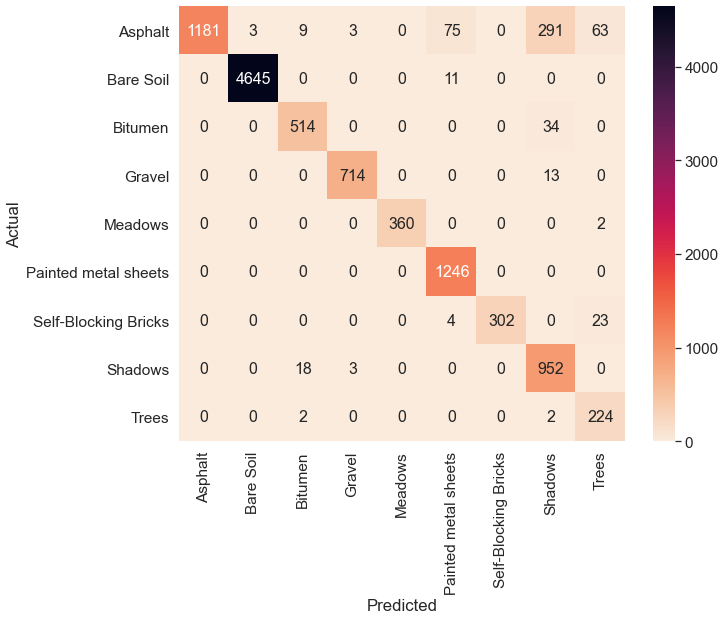

In [19]:
df_cm = pd.DataFrame(Matrix, columns=np.unique(target_names), index = np.unique(target_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="rocket_r", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap_IP_ensemble_model.png', dpi=300)

In [20]:
X, Y = loadData(dataset)

height = Y.shape[0]
width = Y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [21]:
X,pca = applyPCA(X, numComponents)
X = padWithZeros(X, PATCH_SIZE//2)

In [22]:
print('Height - ',height)
print('Width - ',width)

Height -  610
Width -  340


In [23]:
outputs = np.zeros((height,width))

for i in range(height):
    for j in range(width):
        target = int(Y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j,PATCH_SIZE)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (ensemble_try(models, X_test_image))
            #prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

C:\ProgramData\Anaconda3\lib\site-packages\spectral\graphics\spypylab.py:904: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.class_axes = plt.imshow(self.class_rgb, **kwargs)


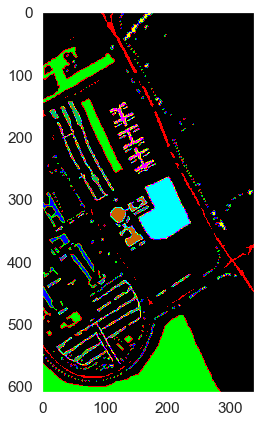

In [24]:
ground_truth = spectral.imshow(classes = Y,figsize =(7,7))

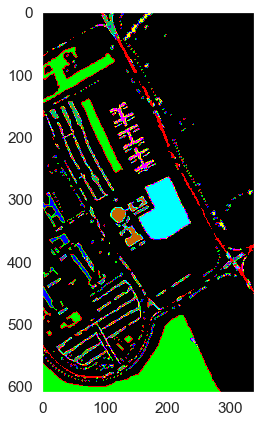

In [25]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [26]:
spectral.save_rgb("predictions_pu.jpg", outputs.astype(int), colors=spectral.spy_colors)